In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

from get_dataset import X_train_tensor as X_train, X_test_tensor as X_test, y_train_tensor as y_train, y_test_tensor as y_test
# from get_dataset import X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

Dataset preview:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  

Dataset shape: (45211, 17)

Categorical columns: ['job', 'marital', 'education', 'default', '

In [2]:
X_train

tensor([[ 0.0060, -0.1686, -0.0969,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.7594,  0.0173,  1.7055,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.1002,  0.8144,  1.8256,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [-0.6532, -0.0149, -0.0969,  ...,  0.0000,  0.0000,  1.0000],
        [-0.7474, -0.3932, -1.0582,  ...,  0.0000,  0.0000,  1.0000],
        [-0.2765, -0.4609,  0.6240,  ...,  0.0000,  0.0000,  1.0000]])

In [3]:
# Define the Logistic Regression model with L1 regularization
class LogisticRegressionL1(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionL1, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# L1 regularization function
# def l1_regularization(model):
def l1_regularization(model, lambda_reg=0.01):
    l2_norm = 0
    for param in model.parameters():
        l2_norm += torch.sum(param ** 2)
    return lambda_reg * l2_norm

# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
model = LogisticRegressionL1(input_dim)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Hyperparameters
num_epochs = 300
lambda_l1 = 0.01  # L1 regularization strength

# Lists to store loss and accuracy
performance = {'train_loss': [], 'test_loss': [], 'train_accuracy': [], 'test_accuracy': []}

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass (train set)
    outputs_train = model(X_train)
    loss_train = criterion(outputs_train, y_train)
    
    # Apply L1 regularization
    l1_loss = l1_regularization(model)
    loss_train += lambda_l1 * l1_loss
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    # Calculate train accuracy
    with torch.no_grad():
        predictions_train = (outputs_train > 0.5).float()
        train_accuracy = (predictions_train == y_train).float().mean()
        
        # Calculate test loss and accuracy
        outputs_test = model(X_test)
        loss_test = criterion(outputs_test, y_test)
        predictions_test = (outputs_test > 0.5).float()
        test_accuracy = (predictions_test == y_test).float().mean()
    
    # Store loss and accuracy
    performance['train_loss'].append(loss_train.item())
    performance['test_loss'].append(loss_test.item())
    performance['train_accuracy'].append(train_accuracy.item())
    performance['test_accuracy'].append(test_accuracy.item())

# Function to plot performance (same as before)
def plot_performance(performance):
    '''
    Function for plotting training and test losses and accuracies
    '''
    plt.style.use('seaborn-v0_8-dark')
    fig, ax = plt.subplots(1, 2, figsize=(16, 4.5))
    
    # Plot loss (train vs test)
    ax[0].plot(performance['train_loss'], label='Train Loss')
    ax[0].plot(performance['test_loss'], label='Test Loss')
    ax[0].set(title="Loss over epochs", xlabel='Epoch', ylabel='Loss')
    
    # Plot accuracy (train vs test)
    ax[1].plot(performance['train_accuracy'], label='Train Accuracy')
    ax[1].plot(performance['test_accuracy'], label='Test Accuracy')
    ax[1].set(title="Accuracy over epochs", xlabel='Epoch', ylabel='Accuracy')

    ax[0].legend()
    ax[1].legend()

    plt.show()
    plt.style.use('default')


In [4]:
print("final test accuracy: ", performance['test_accuracy'][-1])

final test accuracy:  0.8776954412460327


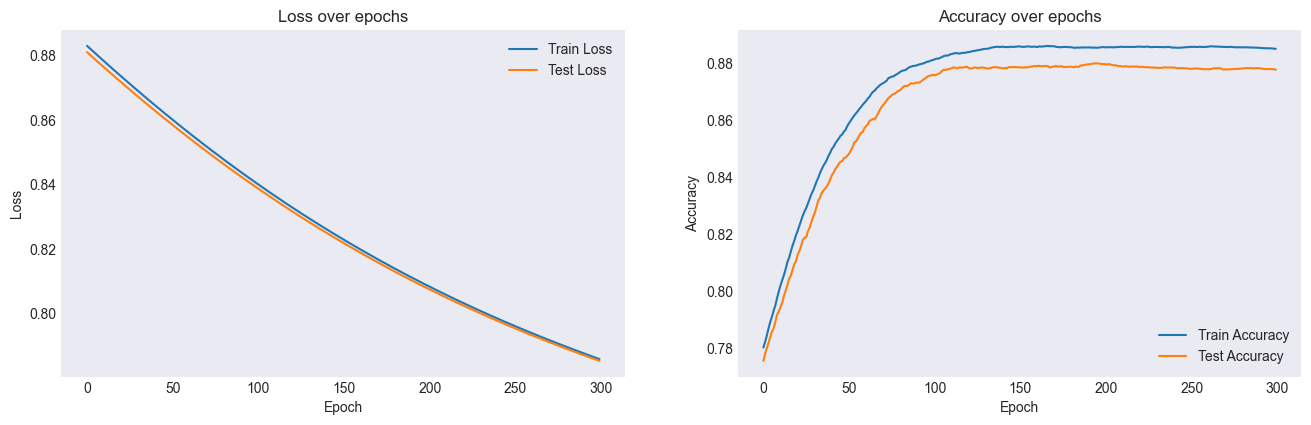

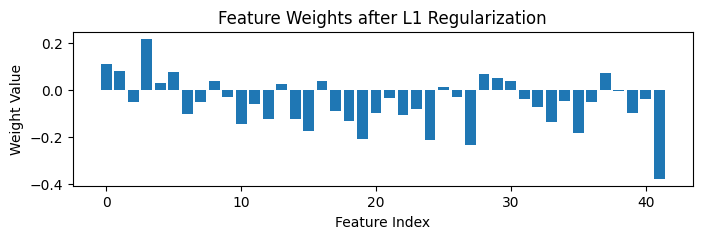

In [5]:

# Plot the performance results
plot_performance(performance)


# Assuming 'model' is the trained logistic regression model
# Print model parameters (weights and bias)
# for name, param in model.named_parameters():
#     if 'linear' in name:
#         print(f"Parameter: {name} | Shape: {param.shape}")
#         print(param.data)

# Get the weights and biases
weights = model.linear.weight.data  # Shape: (1, input_dim)
bias = model.linear.bias.data  # Shape: (1,)

# Print the weights for each feature
# print(f"Weights: {weights}")
# print(f"Bias: {bias}")

# Convert weights to a numpy array for easier inspection
weights = weights.squeeze().cpu().numpy()  # Convert to 1D array if it's a row vector

# Visualize the weights (using matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2))
plt.bar(range(len(weights)), weights)
plt.title("Feature Weights after L1 Regularization")
plt.xlabel("Feature Index")
plt.ylabel("Weight Value")
plt.show()
